**Processing airline data Group 10**

In [1]:
import matplotlib.pyplot as plt


# grabbing all csvs in raw folder just because
raw = spark.read.options(header=True,inferSchema=True).csv(['airplane_raw/2001.csv', 
                                                            'airplane_raw/2002.csv',
                                                            'airplane_raw/2003.csv',
                                                            'airplane_raw/2004.csv',
                                                            'airplane_raw/2005.csv',
                                                            'airplane_raw/2006.csv',
                                                            'airplane_raw/2007.csv',
                                                            'airplane_raw/2008.csv',])
                                                            #'airplane_raw/2001.csv'])
#raw = spark.read.options(header=True,inferSchema=True).csv('airplane_raw/1987.csv, airplane_raw/1988.csv,airplane_raw/1989.csv, airplane_raw/1990.csv,airplane_raw/1991.csv, airplane_raw/1992.csv, airplane_raw/1993.csv, airplane_raw/1994.csv, airplane_raw/1995.csv, airplane_raw/1996.csv, airplane_raw/1997.csv, airplane_raw/1998.csv, airplane_raw/1999.csv, airplane_raw/2000.csv,airplane_raw/2001.csv')

raw.printSchema()
#print(raw.take(1))

root
 |-- Year: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- DayofMonth: integer (nullable = true)
 |-- DayOfWeek: integer (nullable = true)
 |-- DepTime: string (nullable = true)
 |-- CRSDepTime: integer (nullable = true)
 |-- ArrTime: string (nullable = true)
 |-- CRSArrTime: integer (nullable = true)
 |-- UniqueCarrier: string (nullable = true)
 |-- FlightNum: integer (nullable = true)
 |-- TailNum: string (nullable = true)
 |-- ActualElapsedTime: string (nullable = true)
 |-- CRSElapsedTime: string (nullable = true)
 |-- AirTime: string (nullable = true)
 |-- ArrDelay: string (nullable = true)
 |-- DepDelay: string (nullable = true)
 |-- Origin: string (nullable = true)
 |-- Dest: string (nullable = true)
 |-- Distance: integer (nullable = true)
 |-- TaxiIn: string (nullable = true)
 |-- TaxiOut: string (nullable = true)
 |-- Cancelled: integer (nullable = true)
 |-- CancellationCode: string (nullable = true)
 |-- Diverted: integer (nullable = true)
 |-- Car

**What are the busiest airports that people fly out of?**

In [2]:
# simply counting records for origin airport (doesnt matter if these flights were cancelled or not, its about intent)

# need to read in metadata for airport names
airport_metadata = spark.read.options(inferSchema=True,header=True).csv('airplane_raw/metadata/airports.csv')
iata_airport_pairs = airport_metadata.select('iata', 'airport','lat', 'long')
# origin_top_10 = raw.select('Origin','Month').withColumnRenamed('Origin','iata')\
#                                     .groupBy('iata','Month')\
#                                     .count()\
#                                     .join(iata_airport_pairs,'iata','inner')\
#                                     .orderBy('count',ascending=False)
origin_top_10 = raw.select('Origin','Month').withColumnRenamed('Origin','iata')\
                                    .groupBy('iata','Month')\
                                    .count()\
                                    .join(iata_airport_pairs,'iata','inner')\
                                    .orderBy('count',ascending=False)
origin_top_10.withColumnRenamed('iata','Origin')
origin_top_10.show()


+----+-----+------+--------------------+-----------+------------+
|iata|Month| count|             airport|        lat|        long|
+----+-----+------+--------------------+-----------+------------+
| ATL|    3|252097|William B Hartsfi...|33.64044444|-84.42694444|
| ORD|    3|243385|Chicago O'Hare In...|  41.979595|-87.90446417|
| ATL|    1|243294|William B Hartsfi...|33.64044444|-84.42694444|
| ATL|    4|242361|William B Hartsfi...|33.64044444|-84.42694444|
| ORD|    1|239588|Chicago O'Hare In...|  41.979595|-87.90446417|
| ORD|    4|236792|Chicago O'Hare In...|  41.979595|-87.90446417|
| ATL|    2|225594|William B Hartsfi...|33.64044444|-84.42694444|
| ATL|    8|222738|William B Hartsfi...|33.64044444|-84.42694444|
| ATL|    7|220392|William B Hartsfi...|33.64044444|-84.42694444|
| ORD|    2|219784|Chicago O'Hare In...|  41.979595|-87.90446417|
| ORD|    8|218304|Chicago O'Hare In...|  41.979595|-87.90446417|
| ORD|    7|216023|Chicago O'Hare In...|  41.979595|-87.90446417|
| ATL|    

In [3]:
origin_top_10.count()

699

# RUN THIS CELL ONLY IF YOU WANT TO PROCESS EVERYTHING IN ONE GO

In [3]:
# PASS centroids, cluster_K, and the field name with features
from pyspark.ml.linalg import Vectors
import pyspark.sql.functions as F
from pyspark.sql import functions as F
from pyspark.sql import SparkSession, Row
from scipy.spatial import distance

import numpy as np

def Add_Distance_To_Cluster_DF(passed_centroid_feature,cluster_NUMBER,Feature_Field_Name, CLUSTER_NUMBER):
    if CLUSTER_NUMBER == None:
        cluster_NUMBER_center = {int(i):[float(passed_centroid_feature[i][j]) for j in range(len(passed_centroid_feature[i]))] 
              for i in range(len(passed_centroid_feature))}
        cluster_NUMBER_newDF_to_add = spark.sparkContext.parallelize([(k,)+(v,) for k,v in cluster_NUMBER_center.items()]).toDF(['prediction','center'])
        cluster_NUMBER = cluster_NUMBER.withColumn('prediction',F.col('prediction'))
        cluster_NUMBER = cluster_NUMBER.join(cluster_NUMBER_newDF_to_add,on='prediction',how='left')

    elif CLUSTER_NUMBER != None:
        cluster_NUMBER_center = {}
        cluster_NUMBER_center[CLUSTER_NUMBER] =  [float(passed_centroid_feature[0][0]),float(passed_centroid_feature[0][1])]
        cluster_NUMBER_newDF_to_add = spark.sparkContext.parallelize([(k,)+(v,) for k,v in 
        cluster_NUMBER_center.items()]).toDF(['prediction','center'])
        cluster_NUMBER = cluster_NUMBER.withColumn('prediction',F.col('prediction'))
        cluster_NUMBER = cluster_NUMBER.join(cluster_NUMBER_newDF_to_add,on='prediction',how='left')
    
    # ADDS DISTANCE
    # get_dist = F.udf(lambda features, center : 
    #                  float(np.linalg.norm(features-center)))  
    get_dist = F.udf(lambda features, center : 
                     float(features.squared_distance(center)))
    
    cluster_NUMBER = cluster_NUMBER.withColumn('distance',get_dist(F.col(Feature_Field_Name),F.col('center')))

    return cluster_NUMBER

# To get the value of the hi
# Pass the iteration value here e.g 
# RETURN : returns just the value in array [1,1]
def get_Highest_Value_cluster_K(cluster_0_first_iteration):
    cluster_first_k_Value = cluster_0_first_iteration.orderBy(F.desc("distance")).take(1)
    spark = SparkSession.builder.getOrCreate()
    cluster_first_k_Value_DF = spark.createDataFrame(cluster_first_k_Value)
    # cluster_first_k_Value_DF.show()

    # Get the cluster value that are nested
    cluster_0_first_Value = cluster_first_k_Value[0][5]
    # cluster_0_first_Value

    # Converts features of max row into array so it can work with Add_Distance_To_Cluster_DF
    cluster_first_k_Value_max =  np.array(cluster_first_k_Value_DF.select('busy_season_fly_out_of_features').collect())
    cluster_first_k_Value_max = cluster_first_k_Value_max[0]

    return cluster_first_k_Value_max

# This creates a list of the row with max distance
# Pass the iteration value here e.g 
# RETURN : returns complete row of the max value
def get_row_of_highest_value_in_distance_k(cluster_0_first_iteration):
    cluster_first_k_Value = cluster_0_first_iteration.orderBy(F.desc("distance")).take(1)
    spark = SparkSession.builder.getOrCreate()
    cluster_first_k_Value_DF = spark.createDataFrame(cluster_first_k_Value)
    return cluster_first_k_Value_DF

+----+-----+------+--------------------+-----------+------------+-------------------------------+
|iata|Month| count|             airport|        lat|        long|busy_season_fly_out_of_features|
+----+-----+------+--------------------+-----------+------------+-------------------------------+
| ATL|    3|252097|William B Hartsfi...|33.64044444|-84.42694444|           [-84.42694444,33....|
| ORD|    3|243385|Chicago O'Hare In...|  41.979595|-87.90446417|           [-87.90446417,41....|
| ATL|    1|243294|William B Hartsfi...|33.64044444|-84.42694444|           [-84.42694444,33....|
| ATL|    4|242361|William B Hartsfi...|33.64044444|-84.42694444|           [-84.42694444,33....|
| ORD|    1|239588|Chicago O'Hare In...|  41.979595|-87.90446417|           [-87.90446417,41....|
| ORD|    4|236792|Chicago O'Hare In...|  41.979595|-87.90446417|           [-87.90446417,41....|
| ATL|    2|225594|William B Hartsfi...|33.64044444|-84.42694444|           [-84.42694444,33....|
| ATL|    8|222738|W

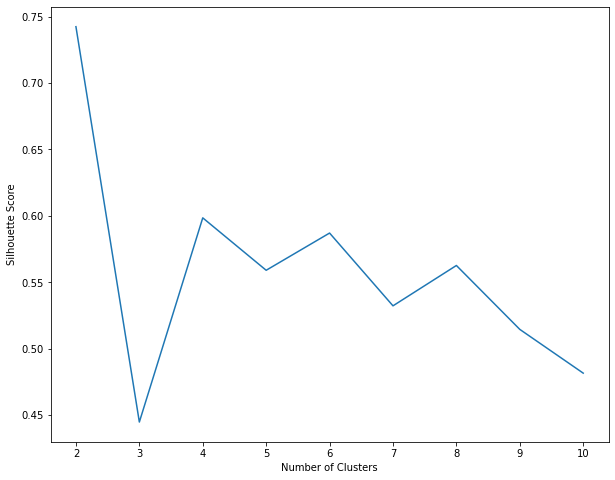

In [4]:
## Add Vector Assembler for silhouette score

from pyspark.ml.feature import VectorAssembler

assemble = VectorAssembler(inputCols=[
'long',
'lat'],outputCol = 'busy_season_fly_out_of_features')

busy_season_fly_out_of_data = assemble.transform(origin_top_10)
busy_season_fly_out_of_data.show()


# Silhoute Score before CLustering - This takes 10 mins to execute

from pyspark.ml.clustering import BisectingKMeans
from pyspark.ml.evaluation import ClusteringEvaluator

silhouette_scores=[]
evaluator = ClusteringEvaluator(featuresCol='busy_season_fly_out_of_features', \
metricName='silhouette')
for K in range(2,11):

    BKMeans_=BisectingKMeans(featuresCol='busy_season_fly_out_of_features', k=K, minDivisibleClusterSize =1)

    BKMeans_fit=BKMeans_.fit(busy_season_fly_out_of_data)

    BKMeans_transform=BKMeans_fit.transform(busy_season_fly_out_of_data) 

    evaluation_score=evaluator.evaluate(BKMeans_transform)

    silhouette_scores.append(evaluation_score)

import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1, figsize =(10,8))
ax.plot(range(2,11),silhouette_scores)
ax.set_xlabel('Number of Clusters')
ax.set_ylabel('Silhouette Score')


### BisectingKMeans/Hierarchical Clustering

BKMeans_=BisectingKMeans(featuresCol='busy_season_fly_out_of_features', k=3) 
BKMeans_Model=BKMeans_.fit(busy_season_fly_out_of_data)
BKMeans_transform=BKMeans_Model.transform(busy_season_fly_out_of_data)
# BKMeans_transform.show()

centroids = BKMeans_Model.clusterCenters()

In [7]:
cluster_0 = BKMeans_transform.filter(BKMeans_transform.prediction==0)
cluster_1 = BKMeans_transform.filter(BKMeans_transform.prediction==1)
cluster_2 = BKMeans_transform.filter(BKMeans_transform.prediction==2)


In [8]:
# ## Add Vector Assembler for silhouette score

# PASS centroids, cluster_K, and the field name with features
from pyspark.ml.linalg import Vectors
import pyspark.sql.functions as F
from pyspark.sql import functions as F
from pyspark.sql import SparkSession, Row
import numpy as np

##################################################
##################################################
#####
##### Cluster 1
#####
##################################################
##################################################

################################################ FIRST ITERATION
cluster_0_first_iteration = Add_Distance_To_Cluster_DF(centroids,cluster_0,'busy_season_fly_out_of_features', None)
# cluster_0_first_iteration.show()


cluster_0_first_k_Value = get_Highest_Value_cluster_K(cluster_0_first_iteration) # THIS JUST GETS THE MAX DIST VALUES THAT WILL BE USED AS CENTER FOR NEXT ITERATION
# the value below will be stored in a list and used in processing dataset again
cluster_0_first_k_Value_row = get_row_of_highest_value_in_distance_k(cluster_0_first_iteration)
# cluster_first_k_Value_row



################################################ SECOND ITERATION
CENTER_FEATURE_POINTS_FOR_SECOND_ITERATION = cluster_0_first_k_Value
CURRENT_CLUSTER_BEING_PROCESSED = cluster_0
CLUSTER_K_BEING_PROCESSED = None # for 0 its None

cluster_0_second_iteration = Add_Distance_To_Cluster_DF(CENTER_FEATURE_POINTS_FOR_SECOND_ITERATION,CURRENT_CLUSTER_BEING_PROCESSED,'busy_season_fly_out_of_features',CLUSTER_K_BEING_PROCESSED)
# cluster_0_second_iteration.show()

cluster_0_second_k_Value = get_Highest_Value_cluster_K(cluster_0_second_iteration) # THIS JUST GETS THE MAX DIST VALUES THAT WILL BE USED AS CENTER FOR NEXT ITERATION
# the value below will be stored in a list and used in processing dataset again
cluster_0_second_k_Value_row = get_row_of_highest_value_in_distance_k(cluster_0_second_iteration)
#cluster_0_second_k_Value


# For third iterations distance - lets just subtrack the max value of first and second iteration and use that as center

# passed max values are nested array ->
center_for_third= (abs(cluster_0_first_k_Value[0]-cluster_0_second_k_Value[0]))
temp_val = cluster_0_second_k_Value.copy()
a = center_for_third[0]
b = center_for_third[1]
temp_val[0][0] = a.copy()
temp_val[0][1] = b.copy()
temp_val
center_for_third = temp_val.copy()
center_for_third   ### <---- This value is used to find the third k


################################################ THIRD ITERATION
CENTER_FEATURE_POINTS_FOR_SECOND_ITERATION = center_for_third
CURRENT_CLUSTER_BEING_PROCESSED = cluster_0
CLUSTER_K_BEING_PROCESSED = None # for 0 its None

cluster_0_third_iteration = Add_Distance_To_Cluster_DF(CENTER_FEATURE_POINTS_FOR_SECOND_ITERATION,CURRENT_CLUSTER_BEING_PROCESSED,'busy_season_fly_out_of_features',CLUSTER_K_BEING_PROCESSED)
# cluster_0_third_iteration.show()
# CENTER_FEATURE_POINTS_FOR_THIRD_ITERATION = center_for_third
# cluster_0_third_iteration = Add_Distance_To_Cluster_DF(CENTER_FEATURE_POINTS_FOR_THIRD_ITERATION, cluster_0, 'busy_season_fly_out_of_features')
# cluster_0_third_iteration.show()

cluster_0_third_k_Value = get_Highest_Value_cluster_K(cluster_0_third_iteration) # THIS JUST GETS THE MAX DIST VALUES THAT WILL BE USED AS CENTER FOR NEXT ITERATION
# the value below will be stored in a list and used in processing dataset again

cluster_0_third_k_Value_row = get_row_of_highest_value_in_distance_k(cluster_0_third_iteration)
cluster_0_third_k_Value


##################################################
##################################################
#####
##### Cluster 2
#####
##################################################
##################################################

################################### First Iteration
# first iteration has the last param as None always
cluster_1_first_iteration = Add_Distance_To_Cluster_DF(centroids,cluster_1,'busy_season_fly_out_of_features',None)
# cluster_1_first_iteration.show()


cluster_1_first_k_Value = get_Highest_Value_cluster_K(cluster_1_first_iteration) # THIS JUST GETS THE MAX DIST VALUES THAT WILL BE USED AS CENTER FOR NEXT ITERATION
# the value below will be stored in a list and used in processing dataset again
cluster_1_first_k_Value_row = get_row_of_highest_value_in_distance_k(cluster_1_first_iteration)
# cluster_first_k_Value_row

cluster_1_first_k_Value




################################### Second Iteration
CENTER_FEATURE_POINTS_FOR_SECOND_ITERATION = cluster_1_first_k_Value
CURRENT_CLUSTER_BEING_PROCESSED = cluster_1
CLUSTER_K_BEING_PROCESSED = 1 # for 0 its None

cluster_1_second_iteration = Add_Distance_To_Cluster_DF(CENTER_FEATURE_POINTS_FOR_SECOND_ITERATION,CURRENT_CLUSTER_BEING_PROCESSED,'busy_season_fly_out_of_features',CLUSTER_K_BEING_PROCESSED)

#cluster_1_second_iteration.show()

# CENTER_FEATURE_POINTS_FOR_SECOND_ITERATION = cluster_1_first_k_Value
# CURRENT_CLUSTER_BEING_PROCESSED = cluster_1
# cluster_1_second_iteration = Add_Distance_To_Cluster_DF(CENTER_FEATURE_POINTS_FOR_SECOND_ITERATION,CURRENT_CLUSTER_BEING_PROCESSED,'busy_season_fly_out_of_features')
# cluster_1_second_iteration.show()


cluster_1_second_k_Value = get_Highest_Value_cluster_K(cluster_1_second_iteration) # THIS JUST GETS THE MAX DIST VALUES THAT WILL BE USED AS CENTER FOR NEXT ITERATION
# the value below will be stored in a list and used in processing dataset again
cluster_1_second_k_Value_row = get_row_of_highest_value_in_distance_k(cluster_1_second_iteration)
cluster_1_second_k_Value


# For third iterations distance - lets just subtrack the max value of first and second iteration and use that as center

# passed max values are nested array ->
cluster_1_center_value_for_third= (abs(cluster_1_first_k_Value[0]-cluster_1_second_k_Value[0]))
temp_val = cluster_1_second_k_Value.copy()
a = cluster_1_center_value_for_third[0]
b = cluster_1_center_value_for_third[1]
temp_val[0][0] = a.copy()
temp_val[0][1] = b.copy()
temp_val
cluster_1_center_value_for_third = temp_val.copy()
cluster_1_center_value_for_third   ### <---- This value is used to find the third k

################################### Third Iteration
CENTER_FEATURE_POINTS_FOR_SECOND_ITERATION = cluster_1_center_value_for_third
CURRENT_CLUSTER_BEING_PROCESSED = cluster_1
CLUSTER_K_BEING_PROCESSED = 1 # for 0 its None

cluster_1_third_iteration = Add_Distance_To_Cluster_DF(CENTER_FEATURE_POINTS_FOR_SECOND_ITERATION,CURRENT_CLUSTER_BEING_PROCESSED,'busy_season_fly_out_of_features',CLUSTER_K_BEING_PROCESSED)

#cluster_1_third_iteration.show()
# cluster_1_third_iteration = Add_Distance_To_Cluster_DF(cluster_1_center_value_for_third,cluster_1,'busy_season_fly_out_of_features')
# cluster_1_third_iteration.show()



cluster_1_third_k_Value = get_Highest_Value_cluster_K(cluster_1_third_iteration) # THIS JUST GETS THE MAX DIST VALUES THAT WILL BE USED AS CENTER FOR NEXT ITERATION
# the value below will be stored in a list and used in processing dataset again

cluster_1_third_k_Value_row = get_row_of_highest_value_in_distance_k(cluster_1_third_iteration)
cluster_1_third_k_Value



# For third iterations distance - lets just subtrack the max value of first and second iteration and use that as center

# passed max values are nested array ->
cluster_1_center_value_for_fourth = (abs(cluster_1_first_k_Value[0]-cluster_1_second_k_Value[0]-cluster_1_third_k_Value[0]))
temp_val = cluster_1_second_k_Value.copy()
a = cluster_1_center_value_for_fourth[0]
b = cluster_1_center_value_for_fourth[1]
temp_val[0][0] = a.copy()
temp_val[0][1] = b.copy()
temp_val
cluster_1_center_value_for_fourth = temp_val.copy()
cluster_1_center_value_for_fourth   ### <---- This value is used to find the third k


##################################################
##################################################
#####
##### Cluster 3
#####
##################################################
##################################################

##################################### FIRST ITERATION

# first iteration has the last param as None always
cluster_2_first_iteration = Add_Distance_To_Cluster_DF(centroids,cluster_2,'busy_season_fly_out_of_features',None)
# cluster_1_first_iteration.show()


cluster_2_first_k_Value = get_Highest_Value_cluster_K(cluster_2_first_iteration) # THIS JUST GETS THE MAX DIST VALUES THAT WILL BE USED AS CENTER FOR NEXT ITERATION
# the value below will be stored in a list and used in processing dataset again
cluster_2_first_k_Value_row = get_row_of_highest_value_in_distance_k(cluster_2_first_iteration)
# cluster_first_k_Value_row

cluster_2_first_k_Value



##################################### SECOND ITERATION

CENTER_FEATURE_POINTS_FOR_SECOND_ITERATION = cluster_2_first_k_Value
CURRENT_CLUSTER_BEING_PROCESSED = cluster_2
CLUSTER_K_BEING_PROCESSED = 2 # for 0 its None

cluster_2_second_iteration = Add_Distance_To_Cluster_DF(CENTER_FEATURE_POINTS_FOR_SECOND_ITERATION,CURRENT_CLUSTER_BEING_PROCESSED,'busy_season_fly_out_of_features',CLUSTER_K_BEING_PROCESSED)

# cluster_2_second_iteration.show()



cluster_2_second_k_Value = get_Highest_Value_cluster_K(cluster_2_second_iteration) # THIS JUST GETS THE MAX DIST VALUES THAT WILL BE USED AS CENTER FOR NEXT ITERATION
# the value below will be stored in a list and used in processing dataset again
cluster_2_second_k_Value_row = get_row_of_highest_value_in_distance_k(cluster_2_second_iteration)
cluster_2_second_k_Value





# For third iterations distance - lets just subtrack the max value of first and second iteration and use that as center

# passed max values are nested array ->
cluster_2_center_value_for_third= (abs(cluster_2_first_k_Value[0]-cluster_2_second_k_Value[0]))
temp_val = cluster_2_first_k_Value.copy()
a = cluster_2_center_value_for_third[0]
b = cluster_2_center_value_for_third[1]
temp_val[0][0] = a.copy()
temp_val[0][1] = b.copy()
temp_val
cluster_2_center_value_for_third = temp_val.copy()
cluster_2_center_value_for_third   ### <---- This value is used to find the third k



##################################### THIRD ITERATION

CENTER_FEATURE_POINTS_FOR_SECOND_ITERATION = cluster_2_center_value_for_third
CURRENT_CLUSTER_BEING_PROCESSED = cluster_2
CLUSTER_K_BEING_PROCESSED = 2 # for 0 its None

cluster_2_third_iteration = Add_Distance_To_Cluster_DF(CENTER_FEATURE_POINTS_FOR_SECOND_ITERATION,CURRENT_CLUSTER_BEING_PROCESSED,'busy_season_fly_out_of_features',CLUSTER_K_BEING_PROCESSED)

# cluster_2_third_iteration.show()




cluster_2_third_k_Value = get_Highest_Value_cluster_K(cluster_2_third_iteration) # THIS JUST GETS THE MAX DIST VALUES THAT WILL BE USED AS CENTER FOR NEXT ITERATION
# the value below will be stored in a list and used in processing dataset again

cluster_2_third_k_Value_row = get_row_of_highest_value_in_distance_k(cluster_2_third_iteration)
cluster_2_third_k_Value



def move_fraction_closer_to_centroid(passed_cluster_k_value, passed_cluster, a , b):
    temp_a = 0
    temp_b = 0
    if float(passed_cluster_k_value[0][0]) >=  float(passed_cluster[0]):
        temp_a = passed_cluster_k_value[0][0] - a        
    if float(passed_cluster_k_value[0][1]) >=  float(passed_cluster[1]):
        temp_b = passed_cluster_k_value[0][1] - b
    if float(passed_cluster_k_value[0][0]) <  float(passed_cluster[0]):
        temp_a = passed_cluster_k_value[0][0] + a     
    if float(passed_cluster_k_value[0][1]) <  float(passed_cluster[1]):
        temp_b = passed_cluster_k_value[0][1] + a
        
    passed_cluster_k_value = [temp_a, temp_b]
    return passed_cluster_k_value


cluster_0_first_k_Value_temp = cluster_0_first_k_Value.copy()
cluster_0_second_k_Value_temp = cluster_0_second_k_Value.copy()
cluster_0_third_k_Value_temp = cluster_0_third_k_Value.copy()

cluster_centroid = centroids[0]

a = cluster_0_first_k_Value_temp[0][0] * 0.2
b = cluster_0_first_k_Value_temp[0][1] * 0.2

cluster_0_first_k_Value_temp = move_fraction_closer_to_centroid(cluster_0_first_k_Value_temp, cluster_centroid, a, b)
cluster_0_first_k_Value = {}
cluster_0_first_k_Value['features'] = cluster_0_first_k_Value_temp
cluster_0_first_k_Value['prediction'] = 0


a = cluster_0_second_k_Value_temp[0][0] * 0.2
b = cluster_0_second_k_Value_temp[0][1] * 0.2
cluster_0_second_k_Value_temp = move_fraction_closer_to_centroid(cluster_0_second_k_Value_temp, cluster_centroid, a, b)
cluster_0_second_k_Value = {}
cluster_0_second_k_Value['features'] = cluster_0_second_k_Value_temp
cluster_0_second_k_Value['prediction'] = 0


a = cluster_0_third_k_Value_temp[0][0] * 0.2
b = cluster_0_third_k_Value_temp[0][1] * 0.2
cluster_0_third_k_Value_temp = move_fraction_closer_to_centroid(cluster_0_third_k_Value_temp, cluster_centroid, a, b)
cluster_0_third_k_Value = {}
cluster_0_third_k_Value['features'] = cluster_0_third_k_Value_temp
cluster_0_third_k_Value['prediction'] = 0


cluster_1_first_k_Value_temp = cluster_1_first_k_Value.copy()
cluster_1_second_k_Value_temp = cluster_1_second_k_Value.copy()
cluster_1_third_k_Value_temp = cluster_1_third_k_Value.copy()

cluster_centroid = centroids[1]


a = cluster_1_first_k_Value_temp[0][0] * 0.2
b = cluster_1_first_k_Value_temp[0][1] * 0.2
cluster_1_first_k_Value_temp = move_fraction_closer_to_centroid(cluster_1_first_k_Value_temp, cluster_centroid, a, b)
cluster_1_first_k_Value = {}
cluster_1_first_k_Value['features'] = cluster_1_first_k_Value_temp
cluster_1_first_k_Value['prediction'] = 1

a = cluster_1_second_k_Value_temp[0][0] * 0.2
b = cluster_1_second_k_Value_temp[0][1] * 0.2
cluster_1_second_k_Value_temp = move_fraction_closer_to_centroid(cluster_1_second_k_Value_temp, cluster_centroid, a, b)
cluster_1_second_k_Value = {}
cluster_1_second_k_Value['features'] = cluster_1_second_k_Value_temp
cluster_1_second_k_Value['prediction'] = 1

a = cluster_1_third_k_Value_temp[0][0] * 0.2
b = cluster_1_third_k_Value_temp[0][1] * 0.2
cluster_1_third_k_Value_temp = move_fraction_closer_to_centroid(cluster_1_third_k_Value_temp, cluster_centroid, a, b)
cluster_1_third_k_Value = {}
cluster_1_third_k_Value['features'] = cluster_1_third_k_Value_temp
cluster_1_third_k_Value['prediction'] = 1



cluster_2_first_k_Value_temp = cluster_2_first_k_Value.copy()
cluster_2_second_k_Value_temp = cluster_2_second_k_Value.copy()
cluster_2_third_k_Value_temp = cluster_2_third_k_Value.copy()

cluster_centroid = centroids[2]


a = cluster_2_first_k_Value_temp[0][0] * 0.2
b = cluster_2_first_k_Value_temp[0][1] * 0.2
cluster_2_first_k_Value_temp = move_fraction_closer_to_centroid(cluster_2_first_k_Value_temp, cluster_centroid, a, b)
cluster_2_first_k_Value = {}
cluster_2_first_k_Value['features'] = cluster_2_first_k_Value_temp
cluster_2_first_k_Value['prediction'] = 2

a = cluster_2_second_k_Value_temp[0][0] * 0.2
b = cluster_2_second_k_Value_temp[0][1] * 0.2
cluster_2_second_k_Value_temp = move_fraction_closer_to_centroid(cluster_2_second_k_Value_temp, cluster_centroid, a, b)
cluster_2_second_k_Value = {}
cluster_2_second_k_Value['features'] = cluster_2_second_k_Value_temp
cluster_2_second_k_Value['prediction'] = 2

a = cluster_2_third_k_Value_temp[0][0] * 0.2
b = cluster_2_third_k_Value_temp[0][1] * 0.2
cluster_2_third_k_Value_temp = move_fraction_closer_to_centroid(cluster_2_third_k_Value_temp, cluster_centroid, a, b)
cluster_2_third_k_Value = {}
cluster_2_third_k_Value['features'] = cluster_2_third_k_Value_temp
cluster_2_third_k_Value['prediction'] = 2


comparison = [cluster_0_first_k_Value,
cluster_0_second_k_Value,
cluster_0_third_k_Value,
cluster_1_first_k_Value,
cluster_1_second_k_Value,
cluster_1_third_k_Value,
cluster_2_first_k_Value,
cluster_2_second_k_Value,
cluster_2_third_k_Value]


for i in comparison:
    print(i)



{'features': [-182.99262636, 46.199974224], 'prediction': 0}
{'features': [-98.03002224000001, 39.0342], 'prediction': 0}
{'features': [-211.97523672, 41.502371112], 'prediction': 0}
{'features': [-70.503672, 35.588058664], 'prediction': 1}
{'features': [-116.8814004, 38.368933600000005], 'prediction': 1}
{'features': [-125.77420572, 32.924578000000004], 'prediction': 1}
{'features': [-103.485867672, 34.535590448], 'prediction': 2}
{'features': [-53.718777776, 4.825999995999998], 'prediction': 2}
{'features': [-95.970513996, 29.860374664], 'prediction': 2}


## PASS 2 OF CURE ALGORITHM
### RESCAN WHOLE DATASET AND COMPARE EACH POINT WITH REPRESENTATIVE POINTS
### CLOSEST POINT CAN BE TAGGED AS CLUSTER K

In [ ]:

## FOR EACH DATA POINT do this:
### given the lat and long - use those x and y in squared distance with each x and y from comparison variable
# calculate the distance for each value in comparison
# then select the smallest distance
# add prediction of that smallest to column prediction


In [14]:
# # simply counting records for origin airport (doesnt matter if these flights were cancelled or not, its about intent)

# # need to read in metadata for airport names
# airport_metadata = spark.read.options(inferSchema=True,header=True).csv('airplane_raw/metadata/airports.csv')
# iata_airport_pairs = airport_metadata.select('iata', 'airport','lat', 'long')
# pass_2_data_origin_top_10 = raw.select('Origin','Month').withColumnRenamed('Origin','iata').join(iata_airport_pairs,'iata','inner')
# # origin_top_10 = raw.select('Origin','Month','Year').where(raw.Year == 1999).withColumnRenamed('Origin','iata')\
# #                                     .groupBy('iata','Month','Year')\
# #                                     .count()\
# #                                     .join(iata_airport_pairs,'iata','inner')\
# #                                     .orderBy('count',ascending=False)
# pass_2_data_origin_top_10.show(20)
# #pass_2_data_origin_top_10.count()


# # lat|long|closest_distance|prediction

+----+-----+--------------------+-----------+------------+
|iata|Month|             airport|        lat|        long|
+----+-----+--------------------+-----------+------------+
| SYR|    1|Syracuse-Hancock ...|43.11118694|-76.10631056|
| SYR|    1|Syracuse-Hancock ...|43.11118694|-76.10631056|
| SYR|    1|Syracuse-Hancock ...|43.11118694|-76.10631056|
| SYR|    1|Syracuse-Hancock ...|43.11118694|-76.10631056|
| SYR|    1|Syracuse-Hancock ...|43.11118694|-76.10631056|
| SYR|    1|Syracuse-Hancock ...|43.11118694|-76.10631056|
| SYR|    1|Syracuse-Hancock ...|43.11118694|-76.10631056|
| SYR|    1|Syracuse-Hancock ...|43.11118694|-76.10631056|
| SYR|    1|Syracuse-Hancock ...|43.11118694|-76.10631056|
| SYR|    1|Syracuse-Hancock ...|43.11118694|-76.10631056|
| SYR|    1|Syracuse-Hancock ...|43.11118694|-76.10631056|
| SYR|    1|Syracuse-Hancock ...|43.11118694|-76.10631056|
| SYR|    1|Syracuse-Hancock ...|43.11118694|-76.10631056|
| SYR|    1|Syracuse-Hancock ...|43.11118694|-76.1063105

In [9]:
# simply counting records for origin airport (doesnt matter if these flights were cancelled or not, its about intent)

# need to read in metadata for airport names
airport_metadata = spark.read.options(inferSchema=True,header=True).csv('airplane_raw/metadata/airports.csv')
iata_airport_pairs = airport_metadata.select('iata', 'airport','lat', 'long')

pass_2_data_origin_top_10 = raw.select('Origin','Month', 'DepDelay').withColumnRenamed('Origin','iata').groupBy('iata','Month').count().orderBy('count',ascending=False).join(iata_airport_pairs,'iata','inner')
df_only_month_depdelay = raw.select('Origin','Month','DepDelay').withColumnRenamed('Origin','iata').groupBy('iata','Month').agg(F.sum('DepDelay').alias("total_DepDelay"))

pass_2_data_origin_top_10 = pass_2_data_origin_top_10.join(df_only_month_depdelay, ["Month", 'iata']).orderBy('count',ascending=False)


pass_2_data_origin_top_10.show(20)



# lat|long|closest_distance|prediction

+-----+----+------+--------------------+-----------+------------+--------------+
|Month|iata| count|             airport|        lat|        long|total_DepDelay|
+-----+----+------+--------------------+-----------+------------+--------------+
|    3| ATL|252097|William B Hartsfi...|33.64044444|-84.42694444|     2835525.0|
|    3| ORD|243385|Chicago O'Hare In...|  41.979595|-87.90446417|     3581528.0|
|    1| ATL|243294|William B Hartsfi...|33.64044444|-84.42694444|     2441995.0|
|    4| ATL|242361|William B Hartsfi...|33.64044444|-84.42694444|     2005134.0|
|    1| ORD|239588|Chicago O'Hare In...|  41.979595|-87.90446417|     3767704.0|
|    4| ORD|236792|Chicago O'Hare In...|  41.979595|-87.90446417|     2653236.0|
|    2| ATL|225594|William B Hartsfi...|33.64044444|-84.42694444|     2629910.0|
|    8| ATL|222738|William B Hartsfi...|33.64044444|-84.42694444|     3263195.0|
|    7| ATL|220392|William B Hartsfi...|33.64044444|-84.42694444|     3652571.0|
|    2| ORD|219784|Chicago O

In [10]:
assemble = VectorAssembler(inputCols=[
'long',
'lat'],outputCol = 'features')

pass_2_data_features = assemble.transform(pass_2_data_origin_top_10)
pass_2_data_features.show()

+-----+----+------+--------------------+-----------+------------+--------------+--------------------+
|Month|iata| count|             airport|        lat|        long|total_DepDelay|            features|
+-----+----+------+--------------------+-----------+------------+--------------+--------------------+
|    3| ATL|252097|William B Hartsfi...|33.64044444|-84.42694444|     2835525.0|[-84.42694444,33....|
|    3| ORD|243385|Chicago O'Hare In...|  41.979595|-87.90446417|     3581528.0|[-87.90446417,41....|
|    1| ATL|243294|William B Hartsfi...|33.64044444|-84.42694444|     2441995.0|[-84.42694444,33....|
|    4| ATL|242361|William B Hartsfi...|33.64044444|-84.42694444|     2005134.0|[-84.42694444,33....|
|    1| ORD|239588|Chicago O'Hare In...|  41.979595|-87.90446417|     3767704.0|[-87.90446417,41....|
|    4| ORD|236792|Chicago O'Hare In...|  41.979595|-87.90446417|     2653236.0|[-87.90446417,41....|
|    2| ATL|225594|William B Hartsfi...|33.64044444|-84.42694444|     2629910.0|[-

In [11]:
import math

def check_distance(x):
    dist = None
    prediction = None
    for i in comparison:
        temp = float(x.squared_distance(i['features']))
        #temp = int( math.sqrt( (i['features'][0] - x[0])**2 + ((i['features'][1] - x[1])**2  ) ))
        if dist == None:
            dist = temp
            prediction = i['prediction']
        elif temp < dist:
            dist = temp
            prediction = i['prediction']
    return prediction

calc_smallest_distance = F.udf(lambda features : check_distance(features))
pass_2_data_features = pass_2_data_features.withColumn('prediction',calc_smallest_distance('features'))
pass_2_data_features.show()


+-----+----+------+--------------------+-----------+------------+--------------+--------------------+----------+
|Month|iata| count|             airport|        lat|        long|total_DepDelay|            features|prediction|
+-----+----+------+--------------------+-----------+------------+--------------+--------------------+----------+
|    3| ATL|252097|William B Hartsfi...|33.64044444|-84.42694444|     2835525.0|[-84.42694444,33....|         2|
|    3| ORD|243385|Chicago O'Hare In...|  41.979595|-87.90446417|     3581528.0|[-87.90446417,41....|         0|
|    1| ATL|243294|William B Hartsfi...|33.64044444|-84.42694444|     2441995.0|[-84.42694444,33....|         2|
|    4| ATL|242361|William B Hartsfi...|33.64044444|-84.42694444|     2005134.0|[-84.42694444,33....|         2|
|    1| ORD|239588|Chicago O'Hare In...|  41.979595|-87.90446417|     3767704.0|[-87.90446417,41....|         0|
|    4| ORD|236792|Chicago O'Hare In...|  41.979595|-87.90446417|     2653236.0|[-87.90446417,41

## Cluster 0 with highest count

In [12]:
# aaaa = pass_2_data_features.groupBy('iata','Month','prediction')\
#                                     .count()\
#                                     .orderBy('count',ascending=False)
# aaaa.show()

In [12]:
cluster2_dataframe = pass_2_data_features.filter(pass_2_data_features.prediction==0)
cluster2_dataframe.sort('count',ascending=False).show()

+-----+----+------+--------------------+-----------+------------+--------------+--------------------+----------+
|Month|iata| count|             airport|        lat|        long|total_DepDelay|            features|prediction|
+-----+----+------+--------------------+-----------+------------+--------------+--------------------+----------+
|    3| ORD|243385|Chicago O'Hare In...|  41.979595|-87.90446417|     3581528.0|[-87.90446417,41....|         0|
|    1| ORD|239588|Chicago O'Hare In...|  41.979595|-87.90446417|     3767704.0|[-87.90446417,41....|         0|
|    4| ORD|236792|Chicago O'Hare In...|  41.979595|-87.90446417|     2653236.0|[-87.90446417,41....|         0|
|    2| ORD|219784|Chicago O'Hare In...|  41.979595|-87.90446417|     3100104.0|[-87.90446417,41....|         0|
|    8| ORD|218304|Chicago O'Hare In...|  41.979595|-87.90446417|     2902053.0|[-87.90446417,41....|         0|
|    7| ORD|216023|Chicago O'Hare In...|  41.979595|-87.90446417|     3235397.0|[-87.90446417,41

In [13]:
from pyspark.sql import functions as f

# cluster2_dataframe = pass_2_data_features.filter(pass_2_data_features.prediction==0)
# cluster2_dataframe.groupBy('iata','Month','count').agg(F.max('count')).sort('count',ascending=False).show()

from pyspark.sql import Window
w = Window.partitionBy('iata')
cluster2_dataframe.withColumn('countB', f.max('count').over(w))\
    .where(f.col('count') == f.col('countB'))\
    .drop('countB').filter(pass_2_data_features.prediction==0).sort('count',ascending=False).show()

+-----+----+------+--------------------+-----------+------------+--------------+--------------------+----------+
|Month|iata| count|             airport|        lat|        long|total_DepDelay|            features|prediction|
+-----+----+------+--------------------+-----------+------------+--------------+--------------------+----------+
|    3| ORD|243385|Chicago O'Hare In...|  41.979595|-87.90446417|     3581528.0|[-87.90446417,41....|         0|
|    3| MSP| 97849|Minneapolis-St Pa...|44.88054694| -93.2169225|      798360.0|[-93.2169225,44.8...|         0|
|    1| CVG| 85338|Cincinnati Northe...|39.04614278| -84.6621725|      723301.0|[-84.6621725,39.0...|         0|
|    1| STL| 62772|Lambert-St Louis ...|38.74768694|-90.35998972|      419633.0|[-90.35998972,38....|         0|
|    3| MDW| 55201|      Chicago Midway| 41.7859825|-87.75242444|      611047.0|[-87.75242444,41....|         0|
|    3| MCI| 39947|Kansas City Inter...|39.29760528|-94.71390556|      264211.0|[-94.71390556,39

## Highest delay in cluster 0

In [14]:
from pyspark.sql import functions as f

# cluster2_dataframe = pass_2_data_features.filter(pass_2_data_features.prediction==0)
# cluster2_dataframe.groupBy('iata','Month','count').agg(F.max('count')).sort('count',ascending=False).show()

cluster2_dataframe.orderBy('total_DepDelay',ascending=False).show()

+-----+----+------+--------------------+-----------+------------+--------------+--------------------+----------+
|Month|iata| count|             airport|        lat|        long|total_DepDelay|            features|prediction|
+-----+----+------+--------------------+-----------+------------+--------------+--------------------+----------+
|    1| ORD|239588|Chicago O'Hare In...|  41.979595|-87.90446417|     3767704.0|[-87.90446417,41....|         0|
|   12| ORD|204950|Chicago O'Hare In...|  41.979595|-87.90446417|     3658780.0|[-87.90446417,41....|         0|
|    3| ORD|243385|Chicago O'Hare In...|  41.979595|-87.90446417|     3581528.0|[-87.90446417,41....|         0|
|    7| ORD|216023|Chicago O'Hare In...|  41.979595|-87.90446417|     3235397.0|[-87.90446417,41....|         0|
|    2| ORD|219784|Chicago O'Hare In...|  41.979595|-87.90446417|     3100104.0|[-87.90446417,41....|         0|
|    6| ORD|210069|Chicago O'Hare In...|  41.979595|-87.90446417|     3015859.0|[-87.90446417,41

## Cluster 1 with highest count

In [14]:
 # aaaa.filter(aaaa.prediction==1).show()

In [15]:
cluster2_dataframe = pass_2_data_features.filter(pass_2_data_features.prediction==1)
cluster2_dataframe.sort('count',ascending=False).show()

+-----+----+------+--------------------+-----------+------------+--------------+--------------------+----------+
|Month|iata| count|             airport|        lat|        long|total_DepDelay|            features|prediction|
+-----+----+------+--------------------+-----------+------------+--------------+--------------------+----------+
|    3| LAX|152254|Los Angeles Inter...|33.94253611|-118.4080744|     1060455.0|[-118.4080744,33....|         1|
|    1| LAX|150707|Los Angeles Inter...|33.94253611|-118.4080744|     1178029.0|[-118.4080744,33....|         1|
|    4| LAX|146477|Los Angeles Inter...|33.94253611|-118.4080744|      860630.0|[-118.4080744,33....|         1|
|    8| LAX|139094|Los Angeles Inter...|33.94253611|-118.4080744|     1021541.0|[-118.4080744,33....|         1|
|    7| LAX|138292|Los Angeles Inter...|33.94253611|-118.4080744|     1084666.0|[-118.4080744,33....|         1|
|    2| LAX|137229|Los Angeles Inter...|33.94253611|-118.4080744|     1120119.0|[-118.4080744,33

In [16]:
from pyspark.sql import Window
w = Window.partitionBy('iata')
cluster2_dataframe.withColumn('countB', f.max('count').over(w))\
    .where(f.col('count') == f.col('countB'))\
    .drop('countB').filter(pass_2_data_features.prediction==1).sort('count',ascending=False).show()

+-----+----+------+--------------------+-----------+------------+--------------+--------------------+----------+
|Month|iata| count|             airport|        lat|        long|total_DepDelay|            features|prediction|
+-----+----+------+--------------------+-----------+------------+--------------+--------------------+----------+
|    3| LAX|152254|Los Angeles Inter...|33.94253611|-118.4080744|     1060455.0|[-118.4080744,33....|         1|
|    3| PHX|130535|Phoenix Sky Harbo...|33.43416667|-112.0080556|     1261966.0|[-112.0080556,33....|         1|
|    3| LAS|109412|McCarran Internat...|36.08036111|-115.1523333|     1048421.0|[-115.1523333,36....|         1|
|    3| DTW|102566|Detroit Metropoli...|42.21205889|-83.34883583|      989354.0|[-83.34883583,42....|         1|
|    3| EWR|100065|         Newark Intl|40.69249722|-74.16866056|     1193978.0|[-74.16866056,40....|         1|
|    3| BOS| 86854|Gen Edw L Logan Intl| 42.3643475|-71.00517917|      731626.0|[-71.00517917,42

## Highest delay in Cluster 1

In [17]:
from pyspark.sql import functions as f

# cluster2_dataframe = pass_2_data_features.filter(pass_2_data_features.prediction==0)
# cluster2_dataframe.groupBy('iata','Month','count').agg(F.max('count')).sort('count',ascending=False).show()

cluster2_dataframe.orderBy('total_DepDelay',ascending=False).show()

+-----+----+------+--------------------+-----------+------------+--------------+--------------------+----------+
|Month|iata| count|             airport|        lat|        long|total_DepDelay|            features|prediction|
+-----+----+------+--------------------+-----------+------------+--------------+--------------------+----------+
|    7| EWR| 86999|         Newark Intl|40.69249722|-74.16866056|     1353971.0|[-74.16866056,40....|         1|
|    3| PHX|130535|Phoenix Sky Harbo...|33.43416667|-112.0080556|     1261966.0|[-112.0080556,33....|         1|
|    8| EWR| 88813|         Newark Intl|40.69249722|-74.16866056|     1242022.0|[-74.16866056,40....|         1|
|    6| EWR| 84134|         Newark Intl|40.69249722|-74.16866056|     1231170.0|[-74.16866056,40....|         1|
|    7| PHX|110911|Phoenix Sky Harbo...|33.43416667|-112.0080556|     1215875.0|[-112.0080556,33....|         1|
|    2| PHX|117093|Phoenix Sky Harbo...|33.43416667|-112.0080556|     1207694.0|[-112.0080556,33

## Cluster 2 with highest count

In [16]:
 # aaaa.filter(aaaa.prediction==2).show()

In [21]:
cluster2_dataframe = pass_2_data_features.filter(pass_2_data_features.prediction==2)
cluster2_dataframe.sort('count',ascending=False).show()

+-----+----+------+--------------------+-----------+------------+--------------+--------------------+----------+
|Month|iata| count|             airport|        lat|        long|total_DepDelay|            features|prediction|
+-----+----+------+--------------------+-----------+------------+--------------+--------------------+----------+
|    3| ATL|252097|William B Hartsfi...|33.64044444|-84.42694444|     2835525.0|[-84.42694444,33....|         2|
|    1| ATL|243294|William B Hartsfi...|33.64044444|-84.42694444|     2441995.0|[-84.42694444,33....|         2|
|    4| ATL|242361|William B Hartsfi...|33.64044444|-84.42694444|     2005134.0|[-84.42694444,33....|         2|
|    2| ATL|225594|William B Hartsfi...|33.64044444|-84.42694444|     2629910.0|[-84.42694444,33....|         2|
|    8| ATL|222738|William B Hartsfi...|33.64044444|-84.42694444|     3263195.0|[-84.42694444,33....|         2|
|    7| ATL|220392|William B Hartsfi...|33.64044444|-84.42694444|     3652571.0|[-84.42694444,33

In [19]:
from pyspark.sql import Window
w = Window.partitionBy('iata')
cluster2_dataframe.withColumn('countB', f.max('count').over(w))\
    .where(f.col('count') == f.col('countB'))\
    .drop('countB').filter(pass_2_data_features.prediction==2).sort('count',ascending=False).show()

+-----+----+------+--------------------+-----------+------------+--------------+--------------------+----------+
|Month|iata| count|             airport|        lat|        long|total_DepDelay|            features|prediction|
+-----+----+------+--------------------+-----------+------------+--------------+--------------------+----------+
|    3| ATL|252097|William B Hartsfi...|33.64044444|-84.42694444|     2835525.0|[-84.42694444,33....|         2|
|    1| DFW|210145|Dallas-Fort Worth...|32.89595056|    -97.0372|     1692189.0|[-97.0372,32.8959...|         2|
|    3| IAH|127679|George Bush Inter...|29.98047222|-95.33972222|     1049997.0|[-95.33972222,29....|         2|
|    3| DEN|120036|         Denver Intl|39.85840806|-104.6670019|     1137516.0|[-104.6670019,39....|         2|
|    3| TPA| 53877|Tampa International |27.97547222|   -82.53325|      504865.0|[-82.53325,27.975...|         2|
|    3| MEM| 40750|Memphis Internati...|35.04241667|-89.97666667|      341336.0|[-89.97666667,35

## Highest delay in cluster 2

In [19]:
from pyspark.sql import functions as f

# cluster2_dataframe = pass_2_data_features.filter(pass_2_data_features.prediction==0)
# cluster2_dataframe.groupBy('iata','Month','count').agg(F.max('count')).sort('count',ascending=False).show()

cluster2_dataframe.orderBy('total_DepDelay',ascending=False).show()

+-----+----+------+--------------------+-----------+------------+--------------+--------------------+----------+
|Month|iata| count|             airport|        lat|        long|total_DepDelay|            features|prediction|
+-----+----+------+--------------------+-----------+------------+--------------+--------------------+----------+
|   12| ORD|534155|Chicago O'Hare In...|  41.979595|-87.90446417|     7926294.0|[-87.90446417,41....|         2|
|    1| ORD|546669|Chicago O'Hare In...|  41.979595|-87.90446417|     7620616.0|[-87.90446417,41....|         2|
|    7| ORD|531262|Chicago O'Hare In...|  41.979595|-87.90446417|     7010633.0|[-87.90446417,41....|         2|
|    6| ORD|516619|Chicago O'Hare In...|  41.979595|-87.90446417|     6866518.0|[-87.90446417,41....|         2|
|    3| ORD|556663|Chicago O'Hare In...|  41.979595|-87.90446417|     6812098.0|[-87.90446417,41....|         2|
|    8| ORD|536420|Chicago O'Hare In...|  41.979595|-87.90446417|     6514646.0|[-87.90446417,41

### Plot the clusters

pca_transformed
+----+-----+------+--------------------+-----------+------------+-------------------------------+--------------------+
|iata|Month| count|             airport|        lat|        long|busy_season_fly_out_of_features|                 pca|
+----+-----+------+--------------------+-----------+------------+-------------------------------+--------------------+
| ATL|    3|252097|William B Hartsfi...|33.64044444|-84.42694444|           [-84.42694444,33....|[88.8198485047912...|
| ORD|    3|243385|Chicago O'Hare In...|  41.979595|-87.90446417|           [-87.90446417,41....|[93.6254343541393...|
| ATL|    1|243294|William B Hartsfi...|33.64044444|-84.42694444|           [-84.42694444,33....|[88.8198485047912...|
| ATL|    4|242361|William B Hartsfi...|33.64044444|-84.42694444|           [-84.42694444,33....|[88.8198485047912...|
| ORD|    1|239588|Chicago O'Hare In...|  41.979595|-87.90446417|           [-87.90446417,41....|[93.6254343541393...|
| ORD|    4|236792|Chicago O'Har

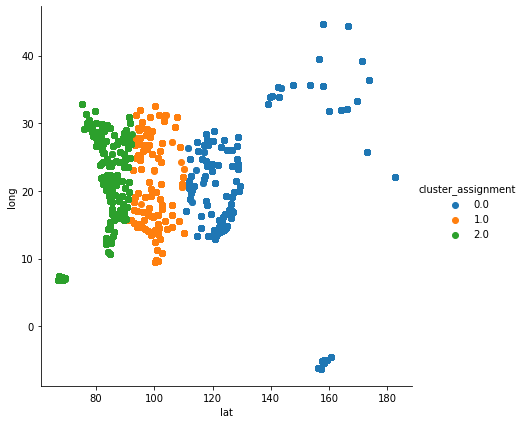

In [5]:
from pyspark.ml.feature import PCA as PCAml
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

pca = PCAml(k=2, inputCol="busy_season_fly_out_of_features", outputCol="pca")
# pca_model = pca.fit(busy_season_fly_out_of_data)
pca_model = pca.fit(BKMeans_transform)
pca_transformed = pca_model.transform(busy_season_fly_out_of_data)
print('pca_transformed')
print(pca_transformed.show())

# BKMeans_=BisectingKMeans(featuresCol='busy_season_fly_out_of_features', k=3) 
# BKMeans_Model=BKMeans_.fit(busy_season_fly_out_of_data)
# BKMeans_transform=BKMeans_Model.transform(busy_season_fly_out_of_data)
# # BKMeans_transform.show()

# extracting the principal components
X_pca = pca_transformed.rdd.map(lambda row: row.pca).collect()
X_pca = np.array(X_pca)

# Retrieve cluster assigned from the above clustering
cluster_assignment = np.array(BKMeans_transform.rdd.map(lambda row: row.prediction).collect()).reshape(-1,1)


# Plotting the data
pca_data = np.hstack((X_pca,cluster_assignment))

pca_df = pd.DataFrame(data=pca_data, columns=("lat", "long","cluster_assignment"))
sns.FacetGrid(pca_df,hue="cluster_assignment", height=6).map(plt.scatter, "lat", "long").add_legend()
plt.show()

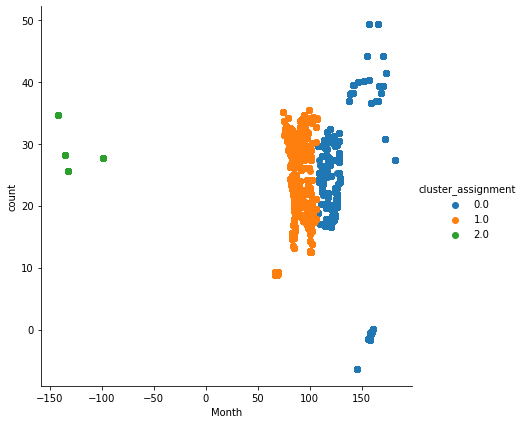

In [12]:
from pyspark.ml.feature import PCA as PCAml
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

pca1 = PCAml(k=2, inputCol="busy_season_fly_out_of_features", outputCol="pca")
# pca_model = pca.fit(busy_season_fly_out_of_data)
pca_model1 = pca1.fit(BKMeans_transform)

pca_transformed1 = pca_model1.transform(busy_season_fly_out_of_data)


# BKMeans_=BisectingKMeans(featuresCol='busy_season_fly_out_of_features', k=3) 
# BKMeans_Model=BKMeans_.fit(busy_season_fly_out_of_data)
# BKMeans_transform=BKMeans_Model.transform(busy_season_fly_out_of_data)
# # BKMeans_transform.show()

# extracting the principal components
X_pca1 = pca_transformed1.rdd.map(lambda row: row.pca).collect()
X_pca1 = np.array(X_pca1)

# Retrieve cluster assigned from the above clustering
cluster_assignment1 = np.array(BKMeans_transform.rdd.map(lambda row: row.prediction).collect()).reshape(-1,1)


# Plotting the data
pca_data1 = np.hstack((X_pca1,cluster_assignment1))

pca_df = pd.DataFrame(data=pca_data1, columns=("Month", "count","cluster_assignment"))
sns.FacetGrid(pca_df,hue="cluster_assignment", height=6).map(plt.scatter, "Month", "count").add_legend()
plt.show()